<h1><b>Méthode : EnKF-LSTM (EnKF)</b></h1>

In [1]:
from kalmanWoFost import KalmanWofostDA
import numpy as np 
from pcse.models import Wofost72_WLP_FD
import datetime as dt
import pandas as pd

from dataloader import Dataloader
import os

from pcse.base import ParameterProvider
from utils import *

## 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.
Dans cet exemple, on va essayer de simuler le champ de notre client


In [2]:
dataloader = Dataloader("data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**
soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


In [3]:

cropd = dataloader.getCropData('potato', 'Innovator')
print(cropd)

YAMLCropDataProvider - current active crop 'potato' with variety 'Innovator'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 3.0, 'TEFFMX': 18.0, 'TSUMEM': 255, 'IDSL': 0, 'DLO': -99.0, 'DLC': -99.0, 'TSUM1': 187, 'TSUM2': 2100, 'DTSMTB': [0.0, 0.0, 2.0, 0.0, 13.0, 11.0, 30.0, 28.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 14.0, 'VERNSAT': 70.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 75.0, 'RGRLAI': 0.017, 'SLATB': [0.0, 0.0017, 1.0, 0.0024, 2.0, 0.0024], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 35.0, 'TBASE': 2.0, 'KDIFTB': [0.0, 1.0, 2.0, 1.0], 'EFFTB': [0.0, 0.49, 40.0, 0.49], 'AMAXTB': [0.0, 33.0, 2.0, 33.0], 'REFCO2L': 400, 'TMPFTB': [0.0, 0.01, 3.0, 0.01, 10.0, 0.75, 15.0, 1.0, 24.0, 1.0, 29.

## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [4]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail()
#plotWofostDF(df_wofost_noDA)

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.210778,22.853864
2022-10-03,1.989233,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.233504,23.990159
2022-10-04,1.993524,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.231734,23.901671
2022-10-05,1.998490,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.230315,23.830729
2022-10-06,2.000000,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.229977,23.813845


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client

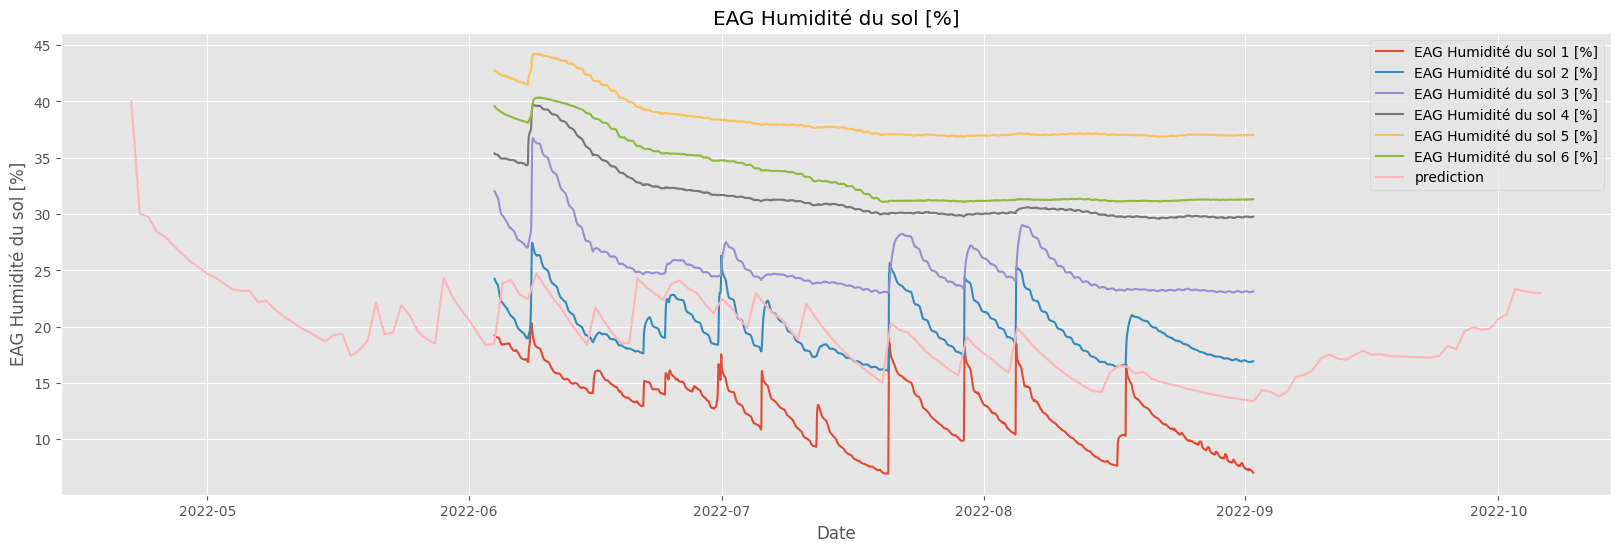

In [5]:
import matplotlib.pyplot as plt

df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

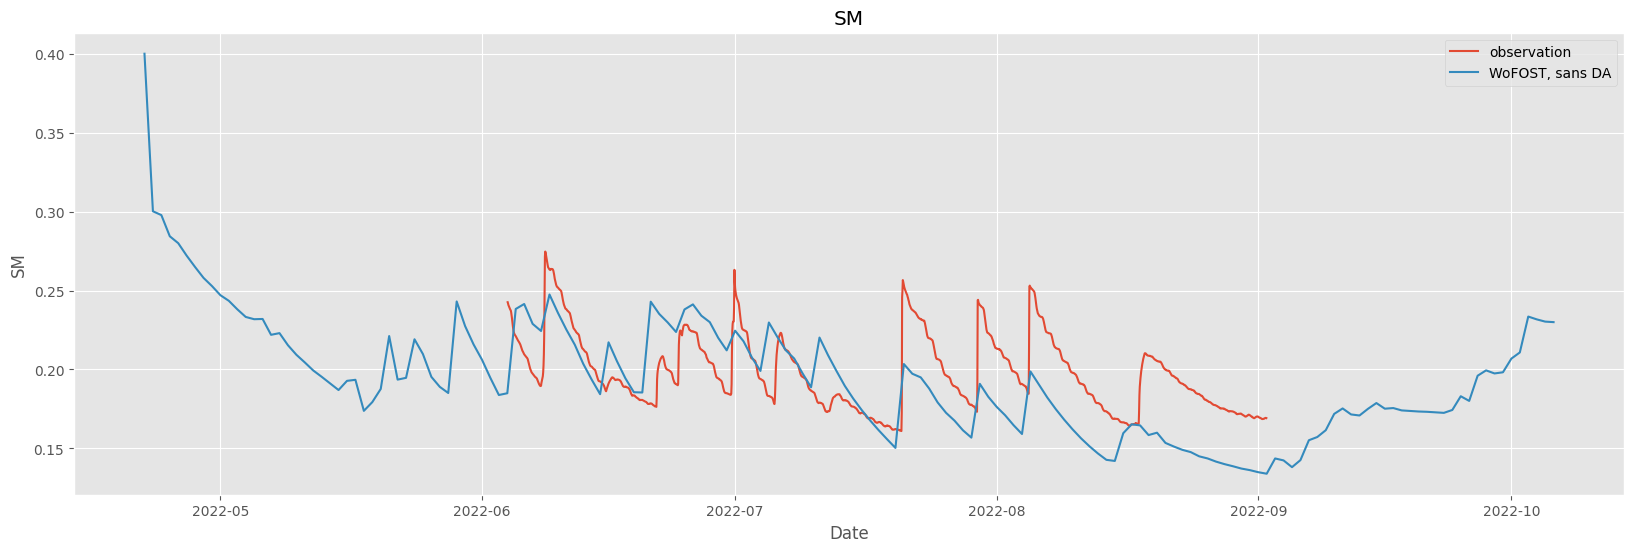

In [6]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition

In [7]:
NB_DAYS_DELTA = 4
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

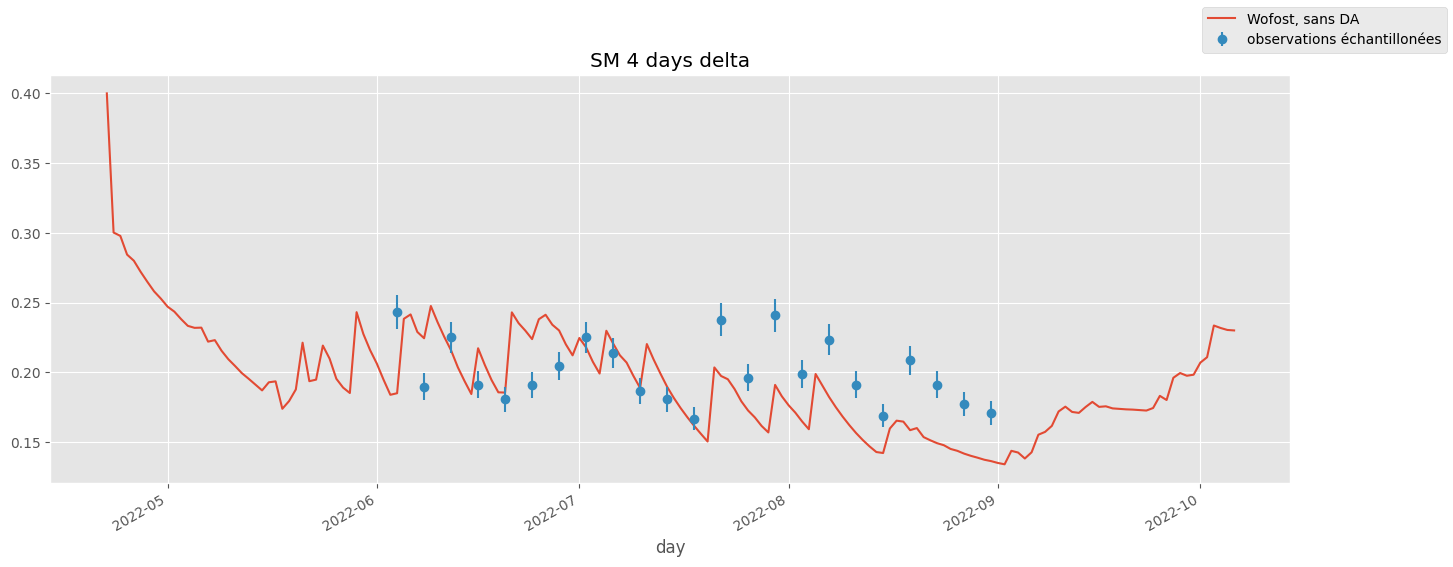

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA")
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

On doit maintenant tout rassembler :

In [9]:
observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]

## 4 - EnKF

On peut maintenant utiliser l'EnKF

Il faut d'abord spécifier les paramètres sur lesquels on a un doute.

In [32]:
ensemble_size = 50
np.random.seed(10000)

print("TDWI", parameters['TDWI'])
print("WAV", parameters["WAV"])
print("SPAN", parameters["SPAN"])
print("SMFCF", parameters["SMFCF"])

TDWI 75.0
WAV 10.0
SPAN 35.0
SMFCF 0.3



On créé ensuite une zone de recherche autour des paramètres que l'on cherche à assimiler.

In [11]:
ensemble_size = 50

override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
# parameters
override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
override_parameters["SMFCF"] = np.maximum(0.05, np.random.normal(parameters['SMFCF'], 0.02 ,(ensemble_size)))

kwf = KalmanWofostDA(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
kwf.batchAssimilate(observations_for_DA)
kwf.completeSim()
df_enkf_DA = kwf.getResultsWithDA()
df_enkf_NODA = kwf.getResultsNoDA()


[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.18969999999999998, 0.009485)} on day 2022-06-08 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1911, 0.009555000000000001)} on day 2022-06-16 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.22510000000000002, 0.011255000000000001)} on day 2022-07-02 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2139, 0.010695000000000001)} on day 2022-07-06 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM'

Finalement, on peut créer et faire tourner notre modèle:

On peut récupérer le résultat de notre simulation

In [12]:
v_t = []

for date, row in df_enkf_DA.iterrows():
    if(date in dates_of_observation):
        for data in observations_for_DA:
            if(data[0] != date):
                continue
            v_t.append(data[1]["SM"][0])
    else:
        v_t.append(-1)

v_t = np.array(v_t)
v_t.shape


(168,)

In [13]:
v_t_reshape = v_t.reshape(-1, 1)[:-1]
v_t_reshape.shape

(167, 1)

In [14]:
X_LSTM = []
Y_LSTM = []

iEssai = 0
while iEssai < 30:
    print("=== Generation n", iEssai,"===")
    try:
        ensemble_size = 50

        override_parameters = {}
        # Initial conditions
        override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
        override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
        # parameters
        override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
        override_parameters["SMFCF"] = np.maximum(0.05, np.random.normal(parameters['SMFCF'], 0.02 ,(ensemble_size)))

        kwf = KalmanWofostDA(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
        kwf.batchAssimilate(observations_for_DA)
        kwf.completeSim()
        df_enkf_DA = kwf.getResultsWithDA()
        df_enkf_NODA = kwf.getResultsNoDA()

        SMs = np.transpose(kwf.getResultsAllModel("SM")) # (nb_donnees, ensemble_size)

        x_lstm = np.concatenate((SMs[:-1], v_t_reshape), axis=1)
        y_lstm = SMs[1:]

        print(x_lstm.shape)
        print(y_lstm)

        X_LSTM.append(x_lstm)
        Y_LSTM.append(y_lstm)
        iEssai += 1
    except:
        print("Error")
        continue

=== Generation n 0 ===
[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.18969999999999998, 0.009485)} on day 2022-06-08 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1911, 0.009555000000000001)} on day 2022-06-16 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.22510000000000002, 0.011255000000000001)} on day 2022-07-02 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2139, 0.010695000000000001)} on day 2022-07-06 00:00:00 
[KalmanWoFoStDA] Assi

In [15]:
X_LSTM = np.array(X_LSTM)
Y_LSTM = np.array(Y_LSTM)

print(X_LSTM.shape, Y_LSTM.shape)

(30, 167, 51) (30, 167, 50)


In [115]:
np.save("X_LSTM", X_LSTM)
np.save("Y_LSTM", Y_LSTM)

In [101]:
import tensorflow as tf

models = []

for TIME in range(v_t_reshape.shape[0]): # TIME of the LSTM model. From all mesures <= TIME, it will predict TIME+1

    if(v_t[TIME] == -1): # Inutile
        models.append(None)
        continue

    print("\n===", TIME,"/", v_t_reshape.shape[0], "===")

    n_features = ensemble_size+1

    # Define LSTM model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(TIME, n_features)))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(ensemble_size))
    #model.summary()
    # Compile model
    model.compile(loss='mse', optimizer='adam')

    # Train model
    X_train = X_LSTM[:,:TIME,:] # input data with shape (batch_size, 10, 1)
    y_train = Y_LSTM[:,TIME,:] # target data with shape (batch_size, 1)

    print(X_train.shape, y_train.shape)
    
    model.fit(X_train, y_train, epochs=50, batch_size=8)

    models.append(model)



=== 43 / 167 ===
(30, 43, 51) (30, 50)
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0695
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0316 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4348e-04 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8833e-04 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4819e-04
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5217e-04
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8936e-04
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7504e-04
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0156e-04 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5494e-05 
Epoch 15/50
4/4 ━━━━━━━━━━━

In [108]:
import copy

override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
# parameters
override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
override_parameters["SMFCF"] = np.maximum(0.05, np.random.normal(parameters['SMFCF'], 0.02 ,(ensemble_size)))

variables_for_DA = ["SM"]

p = copy.deepcopy(parameters)
wofost_before = Wofost72_WLP_FD(p, weatherd, agrod)

show_output = False

ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weatherd, agrod)
    ensemble.append(member)

observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]
while(len(observations_for_DA) > 0):
    day, obs = observations_for_DA.pop(0)
    for member in ensemble:
        member.run_till(day+pd.Timedelta(days=1))
    print("Ensemble now at day %s" % member.day)
    print("%s observations left!" % len(observations_for_DA))

    
    results = []
    for member in ensemble:
        temp = pd.DataFrame(member.get_output())
        temp['day'] = pd.to_datetime(temp['day'], format="%Y-%m-%d")
        temp = temp.set_index("day")
        results.append(temp["SM"].to_numpy()[:-2])
    results = np.array(results)
    
    SMs = np.transpose(results) # (nb_donnees, ensemble_size)
    n_time_actuel = SMs.shape[0]

    print("results:", results.shape)
    print("n_time_actuel", n_time_actuel)

    x_lstm = np.array([np.concatenate((SMs, v_t_reshape[:SMs.shape[0]]), axis=1)])

    #print("SMs", SMs.shape)
    print("x_lstm", x_lstm.shape)
    print(x_lstm[0][1])

    y_lstm = models[n_time_actuel].predict(x_lstm)[0]

    print("y_lstm", y_lstm.shape)
    print(y_lstm)
    
    for i in range(len(ensemble)):
        member = ensemble[i]
        print("Member", i," SM", member.get_variable("SM"), ">", y_lstm[i])
        member.set_variable("SM", y_lstm[i])
    


Ensemble now at day 2022-06-05
22 observations left!
results: (50, 43)
n_time_actuel 43
x_lstm (1, 43, 51)
[ 0.31502829  0.31630967  0.32110111  0.28694913  0.30182855  0.3041658
  0.30707416  0.28560175  0.3167693   0.29941666  0.29517454  0.29439846
  0.32334874  0.29693613  0.33981011  0.3013101   0.27478252  0.32808014
  0.25936418  0.33245432  0.29061138  0.31136603  0.28059743  0.26608869
  0.27838551  0.29639869  0.29643183  0.28678692  0.30318005  0.28639771
  0.31695944  0.27721058  0.33392211  0.31734214  0.28347897  0.2939164
  0.35030127  0.31723266  0.28165053  0.31557503  0.2647368   0.31028553
  0.31522353  0.2960366   0.29398146  0.30337102  0.26545436  0.31436272
  0.33245715  0.32781102 -1.        ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
y_lstm (50,)
[0.2502463  0.24910009 0.2585569  0.25364143 0.25464338 0.2512445
 0.25540367 0.2525367  0.25613898 0.25449747 0.2580914  0.25134853
 0.2522984  0.25561187 0.25592133 0.25300395 0.2521966  0.25498757
 0.25324437 0.2537275

In [81]:
Y_LSTM[0,43,:]

array([0.25167237, 0.24502312, 0.25156975, 0.25225749, 0.25337754,
       0.24837708, 0.24860196, 0.24693061, 0.25162561, 0.25457725,
       0.25156777, 0.25200572, 0.25025285, 0.24856868, 0.25500084,
       0.24252929, 0.24878434, 0.25414806, 0.2534516 , 0.25423123,
       0.25269464, 0.24761136, 0.25363051, 0.25943657, 0.24814907,
       0.25274922, 0.2484747 , 0.25309551, 0.25760736, 0.25534142,
       0.25101484, 0.24896628, 0.25881195, 0.24690444, 0.24296255,
       0.23808818, 0.2465867 , 0.23960811, 0.25373569, 0.24408325,
       0.24479622, 0.24640788, 0.25719551, 0.24537303, 0.25604256,
       0.26393417, 0.26382426, 0.25351964, 0.24657314, 0.24370424])

In [89]:
print(models[43].summary())

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 64)             │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,840 (386.10 KB)

 Trainable params: 32,946 (128.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,894 (257.40 KB)

None


In [85]:

models[43].predict(np.array([X_LSTM[0][:]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


array([[0.31160796, 0.26581776, 0.2978489 , 0.33129323, 0.27317038,
        0.31634074, 0.30088535, 0.31671128, 0.29325032, 0.3290426 ,
        0.29674888, 0.28301546, 0.27431145, 0.26976177, 0.30111492,
        0.30649468, 0.32041124, 0.29756436, 0.34696275, 0.30266264,
        0.28830433, 0.31739458, 0.30405697, 0.27869403, 0.30204484,
        0.28697318, 0.25928065, 0.26170743, 0.3192386 , 0.32285148,
        0.2894133 , 0.26828852, 0.3037484 , 0.2738312 , 0.3577854 ,
        0.27399233, 0.30491218, 0.28130615, 0.30158812, 0.28840688,
        0.32685998, 0.31995472, 0.31213987, 0.27477133, 0.2910295 ,
        0.31335288, 0.2907014 , 0.3137662 , 0.30144283, 0.2543358 ]],
      dtype=float32)

array([[ 0.4       ,  0.4       ,  0.4       , ...,  0.4       ,
         0.4       , -1.        ],
       [ 0.28300003,  0.28478677,  0.29480116, ...,  0.28385699,
         0.30663862, -1.        ],
       [ 0.28057195,  0.28235869,  0.29237307, ...,  0.2814289 ,
         0.30421053, -1.        ],
       ...,
       [ 0.19380169,  0.18770719,  0.19228291, ...,  0.19244371,
         0.19004525, -1.        ],
       [ 0.18289034,  0.17706823,  0.1819521 , ...,  0.1819329 ,
         0.17979452, -1.        ],
       [ 0.18443327,  0.17832895,  0.1833507 , ...,  0.18357724,
         0.18094741,  0.2435    ]])

Résultats

In [109]:
results = []
for member in ensemble:
    temp = pd.DataFrame(member.get_output())
    temp['day'] = pd.to_datetime(temp['day'], format="%Y-%m-%d")
    temp = temp.set_index("day")
    results.append(temp)
concat_df = pd.concat(results)
mean_df = concat_df.groupby(concat_df.index).mean()

In [110]:
observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]
kwf = KalmanWofostDA(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
kwf.batchAssimilate(observations_for_DA)
kwf.completeSim()
df_enkf_DA = kwf.getResultsWithDA()
df_enkf_NODA = kwf.getResultsNoDA()

[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.18969999999999998, 0.009485)} on day 2022-06-08 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1911, 0.009555000000000001)} on day 2022-06-16 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.22510000000000002, 0.011255000000000001)} on day 2022-07-02 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2139, 0.010695000000000001)} on day 2022-07-06 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM'

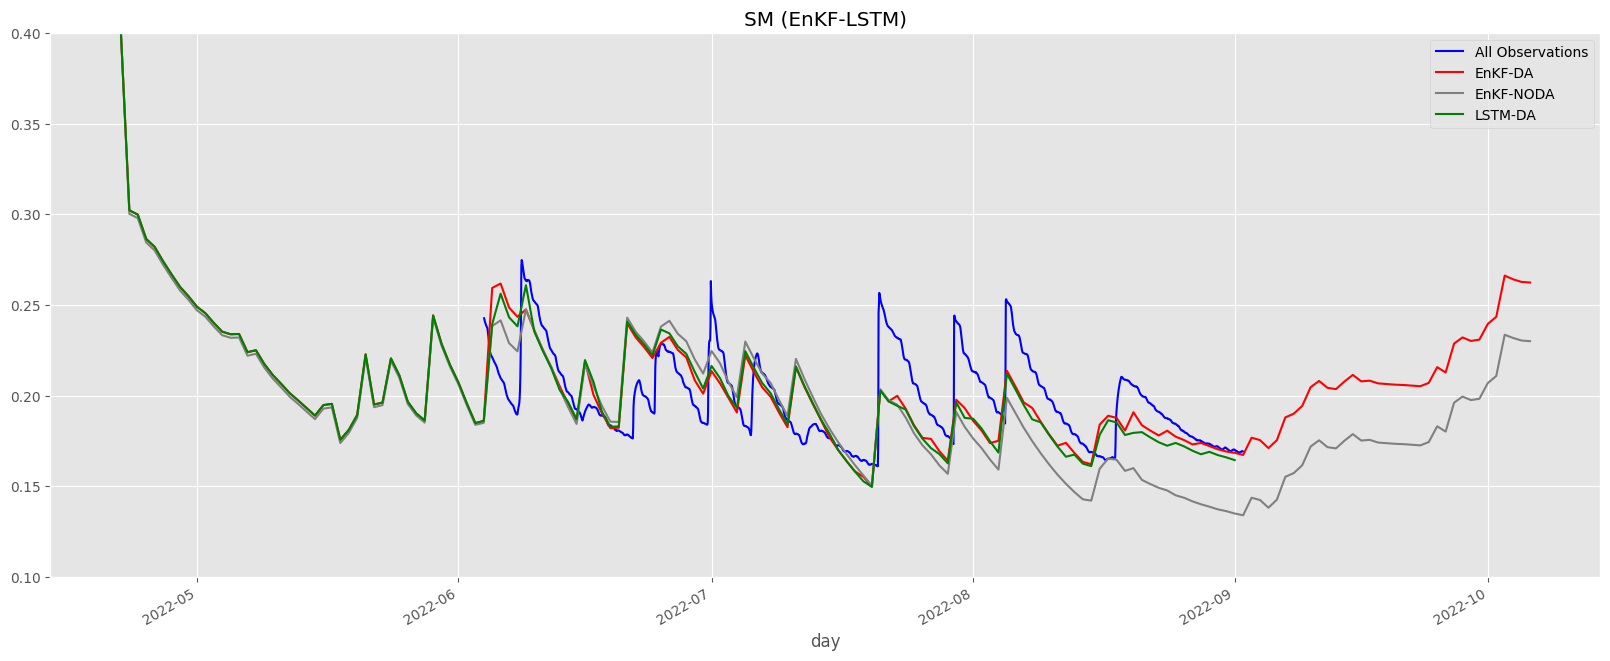

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

axes.plot(df_obs['Date/heure'], df_obs["SM"], label="All Observations", color='b')

#axes.plot(df_enkf_DA.index.to_numpy()[:-1], X_LSTM[14,:,50], label="test", color="black")
df_enkf_DA['SM'].plot(ax=axes, label="EnKF-DA", color='r')
df_enkf_NODA['SM'].plot(ax=axes, label="EnKF-NODA", color='gray')
mean_df['SM'].plot(ax=axes, label="LSTM-DA", color='g')

# axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='RED', label='Observations (sampled)')
axes.set_title("SM (EnKF-LSTM)")
fig.autofmt_xdate()
axes.set_ylim([0.1, 0.4])

axes.legend()

In [54]:
Y_predict = model.predict(X_train[:1])
print(Y_predict)
print(y_train[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.34789503 0.30836812 0.3395254  0.3108935  0.41286585 0.41302738
  0.31192735 0.29661605 0.418589   0.31939533 0.3825024  0.33480978
  0.3031923  0.33008397 0.34787467 0.3439347  0.39790463 0.3789818
  0.30931744 0.34632993 0.33305624 0.33269495 0.32599849 0.29155323
  0.2832869  0.35589105 0.29762158 0.17029487 0.3001756  0.3715446
  0.32975432 0.35348195 0.2659221  0.3395862  0.24330255 0.29782057
  0.41925934 0.41427574 0.29780582 0.34012955 0.39145088 0.40096095
  0.37906274 0.4156917  0.3850117  0.30169657 0.33543238 0.3454496
  0.35270137 0.27334872]]
[[0.27922422 0.3409548  0.38741077 0.24041077 0.32394451 0.24041077
  0.37386765 0.24041077 0.35269198 0.24041077 0.34010399 0.38741077
  0.33862146 0.34714141 0.38741077 0.26639804 0.38741077 0.28710241
  0.38741077 0.24041077 0.26245151 0.24041077 0.33458087 0.30726079
  0.24041077 0.35014564 0.38741077 0.28794496 0.24041077 0.24041077
  0.24041077 0.28042399 0.29171547 0.38741077 0.3874107

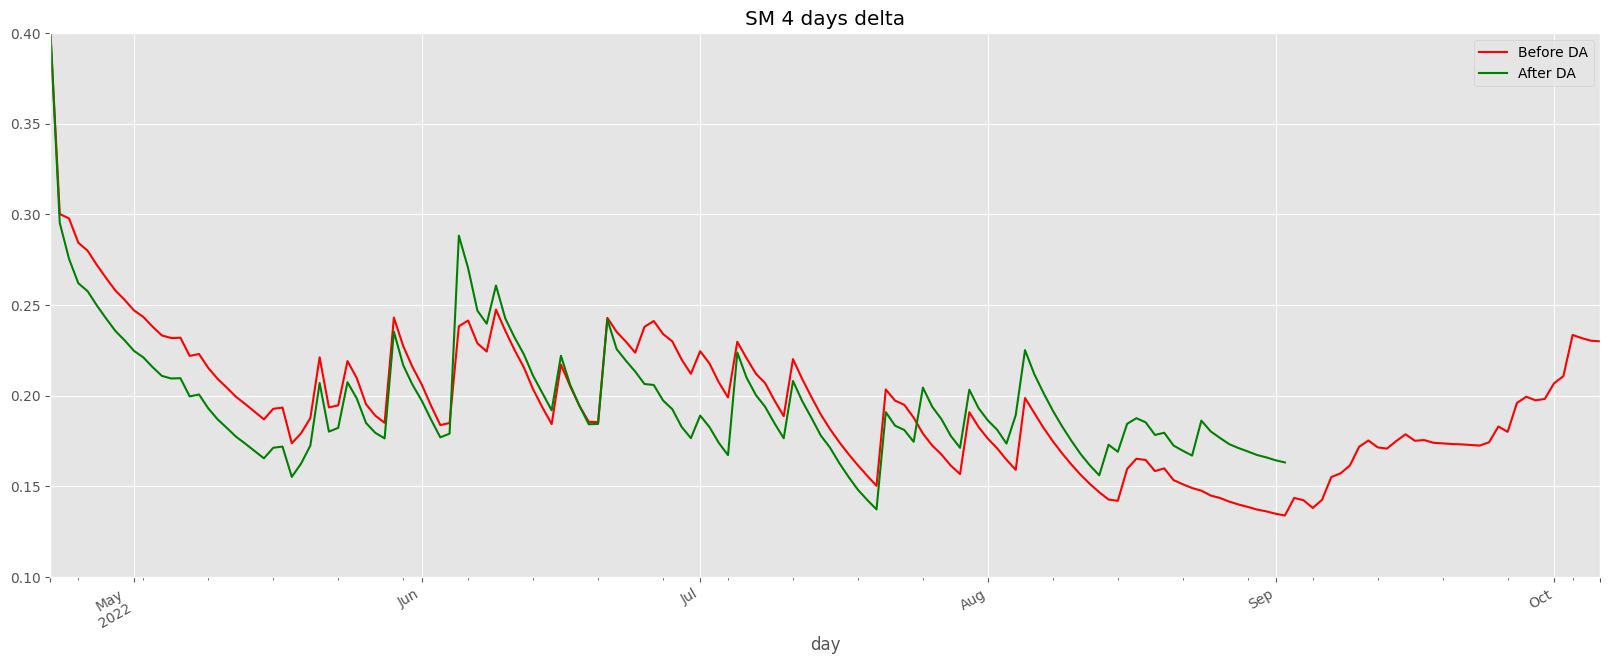

In [119]:
# A container for the parameters that we will override

PARAMETERS_BEFORE = {}
PARAMETERS_BEFORE["TDWI"] = 75.
PARAMETERS_BEFORE["WAV"] = 2.
PARAMETERS_BEFORE["SPAN"] = 36
PARAMETERS_BEFORE["SMFCF"] = 0.272

override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(PARAMETERS_BEFORE['TDWI'], 10, (ensemble_size)))
override_parameters["WAV"] = np.maximum(0.5, np.random.normal(PARAMETERS_BEFORE['WAV'], 1.0, (ensemble_size)))
# parameters
override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(PARAMETERS_BEFORE['SPAN'], 4 ,(ensemble_size)))
override_parameters["SMFCF"] = np.maximum(0.01, np.random.normal(PARAMETERS_BEFORE['SMFCF'], 0.1 ,(ensemble_size)))

p = copy.deepcopy(parameters)
for par, distr in PARAMETERS_BEFORE.items():
    print(par, distr)
    p.set_override(par, distr)

wofost_before = Wofost72_WLP_FD(p, weatherdataprovider, agromanagement)


show_output = False

ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weatherdataprovider, agromanagement)
    ensemble.append(member)

while(len(observations_for_DA) > 0):
    day, obs = observations_for_DA.pop(0)
    for member in ensemble:
        member.run_till(day)
    print("Ensemble now at day %s" % member.day)
    print("%s observations left!" % len(observations_for_DA))

    collected_states = []
    for member in ensemble:
        t = {}
        for state in variables_for_DA:
            t[state] = member.get_variable(state)
        collected_states.append(t)
    df_A = pd.DataFrame(collected_states)
    A = np.matrix(df_A).T

    # Show first 5 rows if output
    df_A.head(5) if show_output else None
        
    P_e = np.matrix(df_A.cov())
    df_A.cov() if show_output else None

    perturbed_obs = []
    for state in variables_for_DA:
        (value, std) = obs[state]
        d = np.random.normal(value, std, (ensemble_size))
        perturbed_obs.append(d)
    df_perturbed_obs = pd.DataFrame(perturbed_obs).T
    df_perturbed_obs.columns = variables_for_DA
    D = np.matrix(df_perturbed_obs).T
    R_e = np.matrix(df_perturbed_obs.cov())

    # Show first 5 rows of perturbed observations if output
    df_perturbed_obs.head(5) if show_output else None

    # Here we compute the Kalman gain
    H = np.identity(len(obs))
    K1 = P_e * (H.T)
    K2 = (H * P_e) * H.T
    K = K1 * ((K2 + R_e).I)
    K if show_output else None

    # Here we compute the analysed states
    Aa = A + K * (D - (H * A))
    df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
    df_Aa.head(5) if show_output else None
    

    for i in range(len(ensemble)):
        member = ensemble[i]
        for state in variables_for_DA:
            member.set_variable(state, df_Aa.iloc[i][state])
    